In [36]:
class Projection_transformer():
    def generate_lat_lon_prj(self, sat_data, aux_data):
        self.x = sat_data['x'][:]
        self.y = sat_data['y'][:]
        
        # Import lat and longitude matrixes taht indicate the corresponding latitude and longitude of each data within the field
        lon_mat, lat_mat = aux_data["lon"][0,:,:] , aux_data["lat"][0,:,:]
        
        # Generate variables needed for the later reshaping of the data
        self.bounds = [np.nanmin(lon_mat.astype(np.float64)), np.nanmax(lon_mat.astype(
            np.float64)), np.nanmin(lat_mat.astype(np.float64)), np.nanmax(lat_mat.astype(np.float64))]
        print(f"Bounds = {self.bounds}")
        Proj4Args = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km'
        Prj = pyproj.Proj(Proj4Args)
        AreaID = 'cyl'
        AreaName = 'cyl'
        ProjID = 'cyl'
        # print(np.nanmin(lon_mat.astype(np.float64)),np.nanmin(lat_mat.astype(np.float64)))
        ny, nx = lon_mat.shape
        # Get the projected poisions of the mst South West and North ast points: Usually outputs sth in the range 5-15
        # I have no idea how it works acually but it works so I wont question it
        SW = Prj(self.bounds[0], self.bounds[2])
        NW = Prj(self.bounds[1], self.bounds[3])
        area_extent = [SW[0], SW[1], NW[0], NW[1]]
        # print(area_extent)
        # The transformation in remap_data transforms th data from SwathDef to AreaDef
        self.AreaDef = get_area_def(
            AreaID, AreaName, ProjID, Proj4Args, nx, ny, area_extent)
        self.SwathDef = SwathDefinition(lons=lon_mat, lats=lat_mat)

        self.generate_new_coordinates()

    def generate_new_coordinates(self):
        self.new_cord_lon = np.linspace(
            self.bounds[0], self.bounds[1], self.x.shape[0])
        self.new_cord_lat = np.linspace(
            self.bounds[2], self.bounds[3], self.y.shape[0])

    def remap_data(self, var_field):
        # Satellite height
        if self.SwathDef == None:
            raise Exception("Error: No projection parameters generated. To generate run Projection_transformer_instance.generate_lat_lon_prj().")
        output_field = np.empty(var_field.shape)
        if len(var_field.shape) == 3:
            output_field = kd_tree.resample_nearest(self.SwathDef, var_field.transpose(1, 2, 0), self.AreaDef, radius_of_influence=60000,
                                                    fill_value=-1, epsilon=5)  # reduce_data=True
            output_field = output_field.transpose(2, 0, 1)
            return output_field
        else:
            raise NotImplementedError("2D var field remapping not yet added")

In [28]:
sat_data=xr.load_dataset("/cluster/work/climate/dnikolo/CLAAS_Data/sample_2024/CPH/ORD57534/CPPin20241001000000405SVMSGI1UD.nc")
aux_data=xr.load_dataset("/cluster/work/climate/dnikolo/CLAAS_Data/claas3_level2_aux_data.nc",decode_times=False)

In [33]:
Transformer=Projection_transformer()
Transformer.remap_data(sat_data,aux_data)


Bounds = [-81.12711304308402, 81.12650389547038, -81.07451709373741, 81.07635224475464]


In [ ]:
aux_data=xr.load_dataset("/cluster/work/climate/dnikolo/CLAAS_Data/claas3_level2_aux_data.nc",decode_times=False)

In [8]:
aux_data=xr.load_dataset("/cluster/work/climate/dnikolo/CLAAS_Data/claas3_level2_aux_data.nc",decode_times=False)
aux

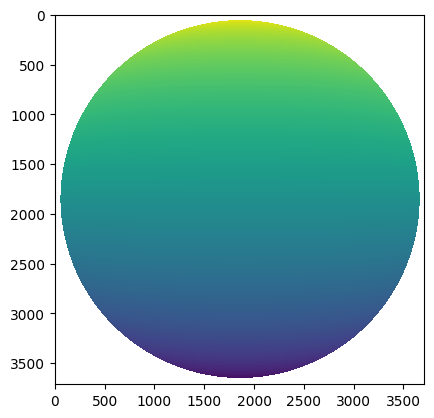

In [14]:
import matplotlib.pyplot as plt
plt.imshow(aux_data["lat"][0,:,:])

In [15]:
aux_data["lat"][0,:,:]

<xarray.DataArray 'lat' (y: 3712, x: 3712)> Size: 110MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    georef_offset_corrected  uint8 1B 0
Dimensions without coordinates: y, x
Attributes:
    long_name:  Latitude
    units:      degrees_north

In [7]:
aux_data.close()

In [ ]:
# from toolz import pipe
# import xarray as xr
from datetime import datetime, timedelta
import numpy as np
import os
from dateutil.relativedelta import relativedelta
from pandas import date_range
# Specify the folder path
#TODO: Make it extract an env variable
global CLAAS_FP 
CLAAS_FP = "/cluster/work/climate/dnikolo/CLAAS_Data/"

def round_time(tm, round_increment):
    """Rounds down the datetime `tm` down to the nearest `round_increment` in minutes."""
    return tm - timedelta(minutes=tm.minute % round_increment, 
                          seconds=tm.second, 
                          microseconds=tm.microsecond)

def generate_month_folder_names(start_time, end_time, round_increment=15):
    """
    Generates a list of month folder names based on time interval.
    
    Parameters:
        start_time (datetime): Start time.
        end_time (datetime): End time.
        round_increment (int): Time interval in minutes.
    
    Returns:
        array: List of folder paths for each time interval.
    """
    # Round start and end times
    start_time = round_time(start_time, round_increment)
    end_time = round_time(end_time, round_increment)
    month_folder_names = date_range(start_time,end_time, 
              freq='MS').strftime("%Y_%m").to_list()
    month_folder_names.append(start_time.strftime("%Y_%m"))
    month_folder_names=set((month_folder_names))
    # month_folder_names=np.array([os.path.join(t.strftime("%Y_%m")) for t in time_range])
    return month_folder_names

def generate_file_names(start_time, end_time, round_increment=15):
    """
    Generates a list of folder paths based on time intervals.
    
    Parameters:
        start_time (datetime): Start time.
        end_time (datetime): End time.
        round_increment (int): Time interval in minutes.
    
    Returns:
        list: List of folder paths for each time interval.
    """
    # Round start and end times
    start_time = round_time(start_time, round_increment)
    end_time = round_time(end_time, round_increment)
    
    # Generate array of time incremented times
    time_range = np.arange(start_time, end_time, timedelta(minutes=round_increment)).astype(datetime)
    # Generate folder paths
    file_names = np.array([os.path.join(t.strftime("%Y_%m"),"CPPin"+t.strftime("%Y%m%d_%H%M%S")+".nc") for t in time_range])
    
    return file_names 

if __name__ == "__main__":
    # Test case
    start_time = datetime(2004, 1, 10, 12, 5)  # Example start time
    end_time = datetime(2024, 10, 1, 14, 5)   # Example end time
    month_folder_names=generate_month_folder_names(start_time, end_time)
    print(month_folder_names)
    unprocessed_folders_list=os.listdir( os.path.join(CLAAS_FP, "Unprocessed_data/"))
    resampled_folders_list=os.listdir( os.path.join(CLAAS_FP, "Resampled_data/"))
    combined_folders_list=unprocessed_folders_list+resampled_folders_list
    assert month_folder_names.issubset(combinde_folder_list), f"One of the month folders doesn't exist in the dataset \nSearched folder names: {month_folder_names} \nExisting folder names: {combined_folders_list}"
    print("Resampled and searched for folders intersection:",np.intersect1d(month_folder_names, np.array(resampled_folders_list)))
    print("Unprocessed and searched for folders intersection:",np.intersect1d(month_folder_names, np.array(unprocessed_folders_list)))
    # target_file_names = generate_file_names(start_time, end_time)
    # existing_files=np.array(os.listdir( os.path.join(CLAAS_FP, "Unprocessed_data/")))
    # existing_files=os.listdir(glob.glob(CLAAS_FP+ '/Unprocessed_data/CPH'+'/*'))
    # existing_files=glob.glob(CLAAS_FP+ '/Unprocessed_data/CPH'+'/*')
    # # comparison_names=existing_files[:][:19]+".nc"

# Loop through the files in the folder
# for filename in os.listdir(folder_path):
#     # Check if the file starts with 'CPPin'
#     if filename.startswith("CPPin"):
#         # Full path of the file
#         new_filename=filename[:19]+".nc"
#         file_path = os.path.join(folder_path, filename)
#         print(f"Processing file: {file_path}")
# xr.load_dataset("/cluster/work/climate/dnikolo/CLAAS_Data/sample_2024/CPH/ORD57534/CPPin20241001000000405SVMSGI1UD.nc")
